In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [2]:
data_dir = 'Preprocessed Data MI'
epoch_data_path = os.path.join(os.getcwd(), data_dir + '\Epoch')
dirs = os.listdir(os.path.join(os.getcwd(), 'Dataset Motor Imagery'))
eeg_data = [mne.read_epochs(os.path.join(epoch_data_path, epoch_file)) for epoch_file in os.listdir(epoch_data_path)]

Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160405-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160408-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     845.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectB-151110-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting 

In [19]:
epoch_data = []
epoch_label = []
subject_last_index = []
# scaler = StandardScaler()
for i in range(len(eeg_data)):
    eeg_data[i] = eeg_data[i].crop(tmin = 0, tmax = 0.845, include_tmax = True)
    for epoch in eeg_data[i].get_data():
#         epoch = scaler.fit_transform(epoch)
        epoch_data.append(np.reshape(epoch, newshape = (epoch.shape[0], epoch.shape[1], 1)))
    for event in eeg_data[i].events:
        epoch_label.append(event[2] - 1)
    subject_last_index.append((dirs[i].split('-')[1], len(epoch_data) - 1))
epoch_data = np.asarray(epoch_data, dtype = np.float32)
epoch_label = np.asarray(epoch_label, dtype = np.int32)

In [20]:
print('Data shape: {}'.format(epoch_data.shape))

Data shape: (17998, 21, 170, 1)


In [5]:
subject_index = {}
for subject, last_index in subject_last_index:
    if subject not in subject_index:
        subject_index[subject] = last_index
    if last_index > subject_index[subject]:
        subject_index[subject] = last_index
subject_index

{'SubjectA': 1825,
 'SubjectB': 5636,
 'SubjectC': 7535,
 'SubjectE': 10383,
 'SubjectF': 13257,
 'SubjectG': 15158,
 'SubjectH': 16080,
 'SubjectI': 17997}

In [6]:
def retrieve_data(subject_name):
    index_list = list(subject_index.values())
    subj_idx = list(subject_index.keys()).index(subject_name)
    if subj_idx - 1 < 0:
        data_index = list(range(index_list[subj_idx]))
    else:
        data_index = list(range(index_list[subj_idx - 1], index_list[subj_idx]))
    return epoch_data[data_index], epoch_label[data_index]

In [7]:
def sliding_window(data, new_data_len, data_gap):
    new_data_indices = []
    data_len = len(data)
    data_start_index, data_end_index = 0, new_data_len
    while data_end_index <= data_len:
        new_data_indices.append(list(range(data_start_index, data_end_index)))
        data_start_index += data_gap
        data_end_index += data_gap
    new_data = [data[data_indices] for data_indices in new_data_indices]
    return new_data

In [21]:
subject_name = 'SubjectB'
data, labels = retrieve_data(subject_name)

In [22]:
data_length, data_gap = 150, 10
copy_data = data.copy()
epoch_data, epoch_label = [], []
for index, data in enumerate(copy_data):
    augmented_data = []
    for channel_index in range(data.shape[0]):
        augmented_data.append(sliding_window(data[channel_index, :, 0], data_length, data_gap))
    augmented_data = np.array(augmented_data)
    for data_index in range(augmented_data.shape[1]):
        new_data = augmented_data[:, data_index]
        new_label = labels[index]
        epoch_data.append(new_data)
        epoch_label.append(new_label)
epoch_data = np.array(epoch_data)
epoch_label = np.array(epoch_label)

In [10]:
shuffled_indices = np.arange(epoch_data.shape[0])
np.random.shuffle(shuffled_indices)

In [23]:
epoch_data = epoch_data[shuffled_indices]
epoch_label = epoch_label[shuffled_indices]

In [24]:
def create_cnn(input_shape, optimizer = None):
    conv1_init = tf.keras.initializers.GlorotUniform(42)
    conv2_init = tf.keras.initializers.GlorotUniform(42)
    dense1_init = tf.keras.initializers.GlorotUniform(24)
    dense2_init = tf.keras.initializers.GlorotUniform(24)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (1, 5), padding = 'same', input_shape = input_shape,
                               activation = 'relu', kernel_initializer = conv1_init),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (input_shape[0], 1), activation = 'relu',
                               kernel_initializer = conv2_init),
        tf.keras.layers.AveragePooling2D(pool_size = (1, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = dense1_init),
        tf.keras.layers.Dense(units = 5, activation = 'softmax', kernel_initializer = dense2_init)
    ])
    if optimizer is None:
        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(5 * 1e-5),
                      metrics = ['accuracy'])
    else:
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [13]:
strat_kfold = StratifiedKFold(n_splits = 10)

In [25]:
losses, acc_scores = [], []
prec_scores, rec_scores = [], []

In [15]:
n_classes = len(np.unique(epoch_label))
for train_index, test_index in strat_kfold.split(epoch_data, epoch_label):
    train_data, test_data = epoch_data[train_index], epoch_data[test_index]
    train_labels, test_labels = epoch_label[train_index], epoch_label[test_index]
    train_data = tf.expand_dims(train_data, axis = -1)
    test_data = tf.expand_dims(test_data, axis = -1)
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = n_classes)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = n_classes)
    
    input_shape = (train_data.shape[1], train_data.shape[2], train_data.shape[3])
    model = create_cnn(input_shape = input_shape)
    history = model.fit(train_data, train_labels, epochs = 30, batch_size = 16, 
                        validation_data = (test_data, test_labels))
    _, acc = model.evaluate(test_data, test_labels)
    predictions = model.predict(test_data)
    predictions = np.array([np.argmax(prediction) for prediction in predictions])
    real_labels = np.array([np.argmax(label) for label in test_labels])
    acc_scores.append(acc)
    prec_scores.append(precision_score(predictions, real_labels, average = 'weighted'))
    rec_scores.append(recall_score(predictions, real_labels, average = 'weighted'))

Epoch 1/30
644/644 [==============================] - 35s 55ms/step - loss: 1.5264 - accuracy: 0.3080 - val_loss: 1.4393 - val_accuracy: 0.3628
Epoch 2/30
644/644 [==============================] - 41s 64ms/step - loss: 1.3701 - accuracy: 0.4143 - val_loss: 1.4277 - val_accuracy: 0.3741
Epoch 3/30
644/644 [==============================] - 43s 66ms/step - loss: 1.2830 - accuracy: 0.4577 - val_loss: 1.3078 - val_accuracy: 0.4467
Epoch 4/30
644/644 [==============================] - 42s 66ms/step - loss: 1.2181 - accuracy: 0.4974 - val_loss: 1.2887 - val_accuracy: 0.4467
Epoch 5/30
644/644 [==============================] - 42s 66ms/step - loss: 1.1552 - accuracy: 0.5242 - val_loss: 1.2558 - val_accuracy: 0.4790
Epoch 6/30
644/644 [==============================] - 42s 66ms/step - loss: 1.0991 - accuracy: 0.5560 - val_loss: 1.2595 - val_accuracy: 0.4808
Epoch 7/30
644/644 [==============================] - 43s 67ms/step - loss: 1.0490 - accuracy: 0.5815 - val_loss: 1.3327 - val_accuracy:

644/644 [==============================] - 45s 70ms/step - loss: 0.1574 - accuracy: 0.9673 - val_loss: 2.1467 - val_accuracy: 0.4589
Epoch 28/30
644/644 [==============================] - 48s 74ms/step - loss: 0.1290 - accuracy: 0.9750 - val_loss: 2.1908 - val_accuracy: 0.4869
Epoch 29/30
644/644 [==============================] - 44s 69ms/step - loss: 0.1065 - accuracy: 0.9844 - val_loss: 2.3139 - val_accuracy: 0.4738
Epoch 30/30
36/36 [==============================] - 2s 42ms/step - loss: 2.4383 - accuracy: 0.4642
Epoch 1/30
644/644 [==============================] - 44s 68ms/step - loss: 1.5281 - accuracy: 0.3096 - val_loss: 1.4180 - val_accuracy: 0.3767
Epoch 2/30
644/644 [==============================] - 44s 68ms/step - loss: 1.3733 - accuracy: 0.4116 - val_loss: 1.3327 - val_accuracy: 0.4100
Epoch 3/30
644/644 [==============================] - 47s 73ms/step - loss: 1.2831 - accuracy: 0.4627 - val_loss: 1.3037 - val_accuracy: 0.4283
Epoch 4/30
644/644 [=========================

644/644 [==============================] - 43s 67ms/step - loss: 0.3049 - accuracy: 0.9111 - val_loss: 1.7982 - val_accuracy: 0.4812
Epoch 23/30
644/644 [==============================] - 45s 69ms/step - loss: 0.2689 - accuracy: 0.9278 - val_loss: 1.8490 - val_accuracy: 0.4646
Epoch 24/30
644/644 [==============================] - 48s 74ms/step - loss: 0.2391 - accuracy: 0.9377 - val_loss: 1.9312 - val_accuracy: 0.4777
Epoch 25/30
644/644 [==============================] - 50s 78ms/step - loss: 0.2053 - accuracy: 0.9513 - val_loss: 1.9979 - val_accuracy: 0.4707
Epoch 26/30
644/644 [==============================] - 51s 79ms/step - loss: 0.1781 - accuracy: 0.9601 - val_loss: 2.0971 - val_accuracy: 0.4724
Epoch 27/30
644/644 [==============================] - 47s 73ms/step - loss: 0.1511 - accuracy: 0.9717 - val_loss: 2.1541 - val_accuracy: 0.4707
Epoch 28/30
644/644 [==============================] - 50s 78ms/step - loss: 0.1298 - accuracy: 0.9770 - val_loss: 2.3389 - val_accuracy: 0.46

644/644 [==============================] - 30s 46ms/step - loss: 0.4820 - accuracy: 0.8380 - val_loss: 1.5026 - val_accuracy: 0.4786
Epoch 18/30
644/644 [==============================] - 32s 50ms/step - loss: 0.4377 - accuracy: 0.8578 - val_loss: 1.5326 - val_accuracy: 0.4838
Epoch 19/30
644/644 [==============================] - 31s 48ms/step - loss: 0.3977 - accuracy: 0.8743 - val_loss: 1.6187 - val_accuracy: 0.4698
Epoch 20/30
644/644 [==============================] - 31s 48ms/step - loss: 0.3543 - accuracy: 0.8928 - val_loss: 1.6624 - val_accuracy: 0.4794
Epoch 21/30
644/644 [==============================] - 31s 48ms/step - loss: 0.3238 - accuracy: 0.9047 - val_loss: 1.7122 - val_accuracy: 0.4864
Epoch 22/30
644/644 [==============================] - 31s 47ms/step - loss: 0.2856 - accuracy: 0.9150 - val_loss: 1.7841 - val_accuracy: 0.4803
Epoch 23/30
644/644 [==============================] - 31s 48ms/step - loss: 0.2444 - accuracy: 0.9372 - val_loss: 1.8313 - val_accuracy: 0.47

644/644 [==============================] - 29s 45ms/step - loss: 0.7200 - accuracy: 0.7376 - val_loss: 1.3719 - val_accuracy: 0.4777
Epoch 13/30
644/644 [==============================] - 29s 46ms/step - loss: 0.6698 - accuracy: 0.7581 - val_loss: 1.3810 - val_accuracy: 0.4829
Epoch 14/30
644/644 [==============================] - 30s 46ms/step - loss: 0.6160 - accuracy: 0.7840 - val_loss: 1.4009 - val_accuracy: 0.4803
Epoch 15/30
644/644 [==============================] - 36s 56ms/step - loss: 0.5679 - accuracy: 0.8052 - val_loss: 1.4739 - val_accuracy: 0.4768
Epoch 16/30
644/644 [==============================] - 41s 64ms/step - loss: 0.5216 - accuracy: 0.8255 - val_loss: 1.4519 - val_accuracy: 0.4821
Epoch 17/30
644/644 [==============================] - 29s 45ms/step - loss: 0.4726 - accuracy: 0.8475 - val_loss: 1.5285 - val_accuracy: 0.4689
Epoch 18/30
644/644 [==============================] - 27s 41ms/step - loss: 0.4277 - accuracy: 0.8642 - val_loss: 1.5906 - val_accuracy: 0.46

644/644 [==============================] - 33s 50ms/step - loss: 1.0290 - accuracy: 0.5949 - val_loss: 1.2336 - val_accuracy: 0.4864
Epoch 8/30
644/644 [==============================] - 34s 53ms/step - loss: 0.9707 - accuracy: 0.6202 - val_loss: 1.2117 - val_accuracy: 0.4969
Epoch 9/30
644/644 [==============================] - 34s 54ms/step - loss: 0.9110 - accuracy: 0.6505 - val_loss: 1.2349 - val_accuracy: 0.4908
Epoch 10/30
644/644 [==============================] - 33s 51ms/step - loss: 0.8589 - accuracy: 0.6690 - val_loss: 1.2090 - val_accuracy: 0.5109
Epoch 11/30
644/644 [==============================] - 33s 52ms/step - loss: 0.8043 - accuracy: 0.6962 - val_loss: 1.2233 - val_accuracy: 0.5057
Epoch 12/30
644/644 [==============================] - 33s 51ms/step - loss: 0.7481 - accuracy: 0.7188 - val_loss: 1.2280 - val_accuracy: 0.5066
Epoch 13/30
644/644 [==============================] - 32s 49ms/step - loss: 0.6956 - accuracy: 0.7442 - val_loss: 1.2606 - val_accuracy: 0.5214

In [26]:
n_classes = len(np.unique(epoch_label))
for train_index, test_index in strat_kfold.split(epoch_data, epoch_label):
    train_data, test_data = epoch_data[train_index], epoch_data[test_index]
    train_labels, test_labels = epoch_label[train_index], epoch_label[test_index]
    train_data = tf.expand_dims(train_data, axis = -1)
    test_data = tf.expand_dims(test_data, axis = -1)
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = n_classes)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = n_classes)
    
    input_shape = (train_data.shape[1], train_data.shape[2], train_data.shape[3])
    model = create_cnn(input_shape = input_shape)
    history = model.fit(train_data, train_labels, epochs = 30, batch_size = 16, 
                        validation_data = (test_data, test_labels))
    _, acc = model.evaluate(test_data, test_labels)
    predictions = model.predict(test_data)
    predictions = np.array([np.argmax(prediction) for prediction in predictions])
    real_labels = np.array([np.argmax(label) for label in test_labels])
    acc_scores.append(acc)
    prec_scores.append(precision_score(predictions, real_labels, average = 'weighted'))
    rec_scores.append(recall_score(predictions, real_labels, average = 'weighted'))

Epoch 1/30
644/644 [==============================] - 26s 41ms/step - loss: 1.5254 - accuracy: 0.3258 - val_loss: 1.4010 - val_accuracy: 0.3864
Epoch 2/30
644/644 [==============================] - 26s 40ms/step - loss: 1.3450 - accuracy: 0.4261 - val_loss: 1.3383 - val_accuracy: 0.4170
Epoch 3/30
644/644 [==============================] - 29s 45ms/step - loss: 1.2494 - accuracy: 0.4828 - val_loss: 1.2865 - val_accuracy: 0.4344
Epoch 4/30
644/644 [==============================] - 30s 47ms/step - loss: 1.1788 - accuracy: 0.5164 - val_loss: 1.2852 - val_accuracy: 0.4502
Epoch 5/30
644/644 [==============================] - 30s 47ms/step - loss: 1.1119 - accuracy: 0.5509 - val_loss: 1.2604 - val_accuracy: 0.4729
Epoch 6/30
644/644 [==============================] - 29s 46ms/step - loss: 1.0517 - accuracy: 0.5784 - val_loss: 1.2567 - val_accuracy: 0.4773
Epoch 7/30
644/644 [==============================] - 30s 47ms/step - loss: 0.9931 - accuracy: 0.6131 - val_loss: 1.2600 - val_accuracy:

644/644 [==============================] - 31s 48ms/step - loss: 0.1514 - accuracy: 0.9715 - val_loss: 2.0032 - val_accuracy: 0.4747
Epoch 28/30
644/644 [==============================] - 30s 47ms/step - loss: 0.1357 - accuracy: 0.9732 - val_loss: 2.0579 - val_accuracy: 0.4799
Epoch 29/30
644/644 [==============================] - 33s 51ms/step - loss: 0.1110 - accuracy: 0.9850 - val_loss: 2.1170 - val_accuracy: 0.4869
Epoch 30/30
36/36 [==============================] - 1s 23ms/step - loss: 2.2895 - accuracy: 0.4720
Epoch 1/30
644/644 [==============================] - 32s 49ms/step - loss: 1.5208 - accuracy: 0.3277 - val_loss: 1.3924 - val_accuracy: 0.3899
Epoch 2/30
644/644 [==============================] - 31s 48ms/step - loss: 1.3461 - accuracy: 0.4336 - val_loss: 1.3218 - val_accuracy: 0.4073
Epoch 3/30
644/644 [==============================] - 31s 48ms/step - loss: 1.2512 - accuracy: 0.4810 - val_loss: 1.2882 - val_accuracy: 0.4344
Epoch 4/30
644/644 [=========================

644/644 [==============================] - 32s 50ms/step - loss: 0.1180 - accuracy: 0.9805 - val_loss: 2.2039 - val_accuracy: 0.4873
Epoch 29/30
644/644 [==============================] - 33s 51ms/step - loss: 0.1019 - accuracy: 0.9860 - val_loss: 2.2906 - val_accuracy: 0.4864
Epoch 30/30
36/36 [==============================] - 1s 33ms/step - loss: 2.2739 - accuracy: 0.5039
Epoch 1/30
644/644 [==============================] - 32s 50ms/step - loss: 1.5177 - accuracy: 0.3268 - val_loss: 1.4353 - val_accuracy: 0.3762
Epoch 2/30
644/644 [==============================] - 33s 51ms/step - loss: 1.3443 - accuracy: 0.4225 - val_loss: 1.3796 - val_accuracy: 0.3885
Epoch 3/30
644/644 [==============================] - 30s 47ms/step - loss: 1.2444 - accuracy: 0.4805 - val_loss: 1.3685 - val_accuracy: 0.4156
Epoch 4/30
644/644 [==============================] - 33s 51ms/step - loss: 1.1038 - accuracy: 0.5538 - val_loss: 1.3150 - val_accuracy: 0.4558
Epoch 6/30
644/644 [==========================

644/644 [==============================] - 30s 47ms/step - loss: 0.2250 - accuracy: 0.9433 - val_loss: 1.7893 - val_accuracy: 0.4838
Epoch 25/30
644/644 [==============================] - 31s 48ms/step - loss: 0.1984 - accuracy: 0.9531 - val_loss: 1.8439 - val_accuracy: 0.4987
Epoch 26/30
644/644 [==============================] - 31s 48ms/step - loss: 0.1718 - accuracy: 0.9601 - val_loss: 1.9542 - val_accuracy: 0.4943
Epoch 27/30
644/644 [==============================] - 31s 48ms/step - loss: 0.1412 - accuracy: 0.9756 - val_loss: 2.0184 - val_accuracy: 0.4759
Epoch 28/30
644/644 [==============================] - 32s 50ms/step - loss: 0.1289 - accuracy: 0.9761 - val_loss: 2.1037 - val_accuracy: 0.4908
Epoch 29/30
644/644 [==============================] - 34s 52ms/step - loss: 0.1081 - accuracy: 0.9815 - val_loss: 2.1796 - val_accuracy: 0.4751
Epoch 30/30
36/36 [==============================] - 1s 28ms/step - loss: 2.2105 - accuracy: 0.4794
Epoch 1/30
644/644 [======================

644/644 [==============================] - 31s 49ms/step - loss: 0.4044 - accuracy: 0.8697 - val_loss: 1.5684 - val_accuracy: 0.4471
Epoch 20/30
644/644 [==============================] - 32s 49ms/step - loss: 0.3666 - accuracy: 0.8893 - val_loss: 1.6166 - val_accuracy: 0.4777
Epoch 21/30
644/644 [==============================] - 31s 49ms/step - loss: 0.3272 - accuracy: 0.9025 - val_loss: 1.7069 - val_accuracy: 0.4567
Epoch 22/30
644/644 [==============================] - 31s 49ms/step - loss: 0.2862 - accuracy: 0.9211 - val_loss: 1.7321 - val_accuracy: 0.4829
Epoch 23/30
644/644 [==============================] - 30s 47ms/step - loss: 0.2526 - accuracy: 0.9313 - val_loss: 1.7644 - val_accuracy: 0.4786
Epoch 24/30
644/644 [==============================] - 29s 45ms/step - loss: 0.2236 - accuracy: 0.9429 - val_loss: 1.8453 - val_accuracy: 0.4777
Epoch 25/30
644/644 [==============================] - 29s 45ms/step - loss: 0.1905 - accuracy: 0.9576 - val_loss: 1.9672 - val_accuracy: 0.48

644/644 [==============================] - 30s 46ms/step - loss: 0.6367 - accuracy: 0.7711 - val_loss: 1.2789 - val_accuracy: 0.5013
Epoch 15/30
644/644 [==============================] - 30s 47ms/step - loss: 0.5970 - accuracy: 0.7938 - val_loss: 1.2866 - val_accuracy: 0.5188
Epoch 16/30
644/644 [==============================] - 31s 47ms/step - loss: 0.5428 - accuracy: 0.8131 - val_loss: 1.3127 - val_accuracy: 0.5057 0.5435 - accu
Epoch 17/30
644/644 [==============================] - 31s 48ms/step - loss: 0.4989 - accuracy: 0.8306 - val_loss: 1.3184 - val_accuracy: 0.5223
Epoch 18/30
644/644 [==============================] - 30s 47ms/step - loss: 0.4566 - accuracy: 0.8521 - val_loss: 1.3765 - val_accuracy: 0.5101
Epoch 19/30
644/644 [==============================] - 36s 57ms/step - loss: 0.4225 - accuracy: 0.8603 - val_loss: 1.3729 - val_accuracy: 0.5153
Epoch 20/30
644/644 [==============================] - 32s 50ms/step - loss: 0.3792 - accuracy: 0.8833 - val_loss: 1.4195 - val_

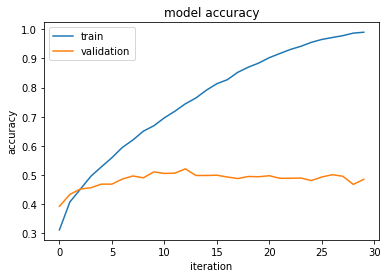

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Hasil/sliding_window.png')
plt.show()

In [17]:
df = pd.DataFrame({'Accuracy': acc_scores, 'Precision': prec_scores,
                   'Recall': rec_scores})
df
# df.to_csv('Hasil/CV_SW_{}.csv'.format(subject_name))

,Accuracy,Precision,Recall
0,0.487762,0.492577,0.487762
1,0.464161,0.467699,0.464161
2,0.475524,0.480708,0.475524
3,0.471566,0.487981,0.471566
4,0.504812,0.505925,0.504812
5,0.480315,0.480286,0.480315
6,0.478565,0.484918,0.478565
7,0.471566,0.474893,0.471566
8,0.489064,0.494944,0.489064
9,0.485564,0.490589,0.485564


In [27]:
df = pd.DataFrame({'Accuracy': acc_scores, 'Precision': prec_scores,
                   'Recall': rec_scores})
df
# df.to_csv('Hasil/CV_SW_{}.csv'.format(subject_name))

,Accuracy,Precision,Recall
0,0.496504,0.499294,0.496503
1,0.472028,0.482305,0.472028
2,0.514860,0.515615,0.514860
3,0.503937,0.503486,0.503937
4,0.509186,0.529837,0.509186
5,0.479440,0.480199,0.479440
6,0.510061,0.518032,0.510061
7,0.466317,0.466643,0.466317
8,0.496938,0.495200,0.496938
9,0.511811,0.519720,0.511811


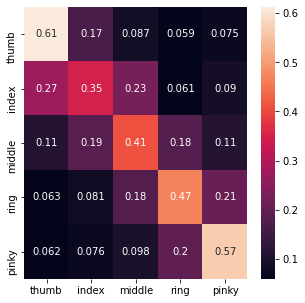

In [18]:
label = ['thumb', 'index', 'middle', 'ring', 'pinky']
cm = confusion_matrix(real_labels, predictions, normalize = 'true')
df_cm = pd.DataFrame(cm, index = label, columns = label)
plt.figure(figsize = (5, 5))
sn.heatmap(df_cm, annot = True)
# plt.savefig('Hasil/CM_{}_SW.png'.format(subject_name), facecolor = 'w', edgecolor = 'w')
plt.show()